# 2.3 Image enhancement

Image enhancement is the process of adjusting a digital image so the resultant one is more suitable for further image analysis (feature extraction, segmentation, etc.), in other words, **its goal is to improve the contrast and brightness of the image**.

There are three typical operations for enhancing images. We have already explored one of them in notebook *2.1 IP tools*: (linear) Look-Up Tables (LUTs). In this notebook we will play with other two:

- Non-linear look-up tables (<a href="#231">Section 2.3.1</a>).
- Histogram equalization (<a href="#232">Section 2.3.2</a>).
- Histogram specification (<a href="233">Section 2.3.3</a>).

Also, some color-space conversions are going to be needed. If you are not familiar with the YCrCb color space, **Appendix 2: Color spaces** contains the information you need to know about it.

## Problem context - Implementing enhancement techniques for an image editor tool

We have all tried an image editor tool, sometimes without even knowing it! For example, modern smartphones already include an application for applying filters to images, cut them, modify their contrast, brightness, color temperature, etc. 

<img src="./images/GIMP-logo.png" width="200">


One example of open source tool is the GNU Image Manipulation Program (GIMP). Quoting some words from its [website](https://www.gimp.org/):  

> GIMP is a cross-platform image editor available for GNU/Linux, OS X, Windows and more operating systems. It is free software, you can change its source code and distribute your changes.
> Whether you are a graphic designer, photographer, illustrator, or scientist, GIMP provides you with sophisticated tools to get your job done. You can further enhance your productivity with GIMP thanks to many customization options and 3rd party plugins.


In this case we were contacted by UMA for implementing two techniques to be included in their own image editor tool! Concretely, we were asked to develop and test two methods that are also part of GIMP: [**gamma correction**](https://docs.gimp.org/2.10/en/gimp-tool-levels.html) and [**equalize**](https://docs.gimp.org/2.10/en/gimp-layer-equalize.html).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

images_path = './images/'

## 2.3.1 Non-linear look-up tables <a id=231></a>

**Gamma correction**, or often simply **gamma**, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems. In other words, it is the result of applying an (already defined) **non-linear LUT** in order to stretch or shrink image intensities.

In this way, the gamma LUT definition for grayscale images, where each pixel $i$ takes values in the range $[0 \dots 255]$, is:

$$LUT(i) = (\frac{i}{255})^{\gamma} * 255, \ \gamma \gt 0 $$

The following images illustrate the application of gamma correction for different values of $\gamma$.

<img src="./images/gamma_theory.jpg" width="800" >

### **<span style="color:green"><b><i>ASSIGNMENT 1: Applying non-linear LUTs</i></b></span>**

Your task is to develop the `lut_chart()` function, which takes as arguments the image to be enhanced and a gamma value for building the non-linear LUT. It will also display a chart containing the original image, the gamma-corrected one, the used LUT and the histogram of the resulting image.

As users from UMA will use color images, you will have to **implement it for color images**. This can be done by:
1. **transforming** a image in the BGR color space **to the YCrCb one**,
2. then, **applying gamma LUT only to first band** of the YCrCb space (that's because it contains pixel intensities and you can handle it like a gray image), and
3. finally, as matplotlib displays RGB images (if verbose is True), it should be **converted back**. Also, return the resultant image.

*Interesting functions:* 
- [`np.copy()`](https://numpy.org/doc/stable/reference/generated/numpy.copy.html): method that returns a copy of the array provided as input.
- [`cv2.LUT()`](https://docs.opencv.org/master/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f): *function that  performs a look-up table transform of an array of arbitrary dimensions.*
- [`plt.hist()`](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html) *function that computes and draws the histogram of an array.  [`numpy.ravel()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) is a good helper here, since it converts a n-dimensional array into a flattened 1D array.* 

In [2]:
# ASSIGNMENT 1
# Implement a function that:
# -- converts the input image from the BGR to the YCrCb color space
# -- creates the gamma LUT
# -- applies the LUT to the original image
# -- displays in a 2x2 plot: the input image, the gamma-corrected one, the applied LUT and the resultant histogram if verbose = True
def lut_chart(image, gamma, verbose=False):
    """ Applies gamma correction to an image and shows the result.   
    
        Args:
            image: Input image
            gamma: Gamma parameter
            verbose: Only show images if this is True
            
        Returns:
            out_image: Gamma image
    """
    
    #Transform image to YCrCb color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    out_image = np.copy(image)
    
    # Define gamma correction LUT
    lut = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply LUT to first band of the YCrCb image
    out_image[:,:,0] = cv2.LUT(image[:,:,0],lut)
    
    if verbose:
        # Plot used LUT
        plt.subplot(2,2,3)
        plt.title('LUT')
        plt.plot(np.arange(256),lut)

        # Plot histogram of gray image after applying the LUT
        plt.subplot(2,2,4)
        plt.hist(image[:,:,0].ravel(), 256, [0,256])
        plt.title('Histogram')

        # Reconvert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)
        out_image = cv2.cvtColor(out_image, cv2.COLOR_YCrCb2RGB)

        # Show the initial image
        plt.subplot(2,2,1)
        plt.imshow(image)
        plt.title('Original image')

        # Show the resultant one
        plt.subplot(2,2,2)
        plt.imshow(out_image)
        plt.title('LUT applied')
        
    return out_image

You can use the next code to **test if results are correct**:

In [3]:
image = np.array([[[10,60,20],[60,22,74],[72,132,2]],[[11,63,42],[36,122,27],[37,113,30]],[[1,6,2],[6,22,7],[7,13,0]]], dtype=np.uint8)
gamma = 2
print(lut_chart(image, gamma))

[[[  6 112 110]
  [  6 151 138]
  [ 29  68 120]]

 [[ 10 122 105]
  [ 27  87 101]
  [ 25  92 104]]

 [[  0 127 126]
  [  1 122 122]
  [  0 122 127]]]


<font color='blue'>**Expected output:**  </font>

    [[[  6 112 110]
      [  6 151 138]
      [ 29  68 120]]

     [[ 10 122 105]
      [ 27  87 101]
      [ 25  92 104]]

     [[  0 127 126]
      [  1 122 122]
      [  0 122 127]]]

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

In the interactive code cell below, **you are asked to** explore how your new `lut_chart()` function works with `gamma_1.jpg` (an underexposed image) and `gamma_2.jpeg` (an overexposed image). Then, **answer the following question** (you can take a look at the LUT and the resulting histogram):

- What is happening when the *gamma value* is modified?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Nos podemos encontrar en tres situaciones distintas:</i></p>  
     <p style="margin: 4px 0px 6px 5px; color:blue"><i>1. Gamma = 1; Los valores de intensidad de los píxeles no se ven afectados.</i></p>
      <p style="margin: 4px 0px 6px 5px; color:blue"><i>2. Gamma > 1; La imagen se tornará a tonos oscuros.</i></p>
       <p style="margin: 4px 0px 6px 5px; color:blue"><i>3. Gamma < 1; La imagen se volverá más clara.</i></p>

In [4]:
# Create widget object
gamma_widget = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.2, description='Gamma:')

#Read image
image = cv2.imread(images_path + 'gamma_2.jpeg',-1)

#Interact with your code!
interactive(lut_chart, image=fixed(image), gamma=gamma_widget, verbose=fixed(True))

interactive(children=(FloatSlider(value=1.0, description='Gamma:', max=5.0, min=0.1, step=0.2), Output()), _do…

## 2.3.2 Histogram equalization <a id=232></a>

**Histogram equalization** is an image processing technique used to improve contrast in images. It operates by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image so each possible pixel intensity appears the same number of times as every other value. This method usually increases the global contrast of images when its usable data is represented by close contrast values. This allows for areas of lower local contrast to gain a higher contrast.

<img src="./images/equalization.png" width="300" />$\\[5pt]$

To put an example, the [**equalize**](https://docs.gimp.org/2.10/en/gimp-layer-equalize.html) command from GIMP applies histogram equalization. But... how is this equalization achieved?

- First it is calculated the PMF ([probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function)) of all the pixels in the image. Basically, this is a normalization of the histogram.

- Next step involves calculation of CDF ([cumulative distributive function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)), producing the LUT for histogram equalization.

- Finally, the obtained LUT is applied. 

The figure below shows an example of applying histogram equalization to an image.$\\[10pt]$

<img src="./images/equalize_theory.png" width="600" />$\\[5pt]$

### **<span style="color:green"><b><i>ASSIGNMENT 2: Equalizing the histogram!</i></b></span>**

Similarly to the previous exercise, **you are asked to** develop a function called `equalize_chart()`. This method takes a **color** image, and will display a plot containing:

- the original image, 
- the equalized image, 
- the original image histogram, and 
- the equalized image histogram.

*Tip: openCV implements histogram equalization in [cv2.equalizeHist()](https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=equalizehist)*

In [5]:
# ASSIGNMENT 2
# Implement a function that:
# -- converts the input image from the BGR to the YCrCb color space
# -- applies the histogram equalization
# -- displays in a 2x2 plot: the input image, the equalized one, the original histogram and the equalized one, if verbose = True
def equalize_chart(image, verbose=False):
    """ Applies histogram equalization to an image and shows the result.   
    
        Args:
            image: Input image
            verbose: Only show images if this is True
            
        Returns:
            out_image: Equalized histogram image
    """

    #Transform image to YCrCb color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    out_image = np.copy(image)
    
    # Apply histogram equalization to first band of the YCrCb image
    out_image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    
    if verbose:

        # Plot histogram of gray image 
        plt.subplot(2,2,3)
        plt.hist(image[:,:,0].ravel(),256,[0,256])
        plt.title('Original histogram')

        # Plot equalized histogram of the processed image
        plt.subplot(2,2,4)
        plt.hist(out_image[:,:,0].ravel(),256,[0,256])
        plt.title('Equalized histogram')

        # Reconvert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)
        out_image = cv2.cvtColor(out_image, cv2.COLOR_YCrCb2RGB)

        # Show the initial image
        plt.subplot(2,2,1)
        plt.imshow(image)
        plt.title('Original image')

        # Show the resultant one
        plt.subplot(2,2,2)
        plt.imshow(out_image)
        plt.title('Equalized histogram image')
        
    return out_image

You can use the next code to **test if your results are correct**:

In [6]:
image = np.array([[[10,60,20],[60,22,74],[72,132,2]],[[11,63,42],[36,122,27],[37,113,30]],[[1,6,2],[6,22,7],[7,13,0]]], dtype=np.uint8)
print(equalize_chart(image))

[[[128 112 110]
  [128 151 138]
  [255  68 120]]

 [[159 122 105]
  [223  87 101]
  [191  92 104]]

 [[  0 127 126]
  [ 64 122 122]
  [ 32 122 127]]]


<font color='blue'>**Expected output:**  </font>

    [[[128 112 110]
      [128 151 138]
      [255  68 120]]

     [[159 122 105]
      [223  87 101]
      [191  92 104]]

     [[  0 127 126]
      [ 64 122 122]
      [ 32 122 127]]]

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

We have developed our second image enhancement technique! Now try `equalize_chart()` with the `park.png` image in the code cell below. Then, **answer following questions**:

- What is the difference between the original histogram and the equalized one?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La principal diferencia entre ambos es que la distribución de la intensidad de los píxeles es mucho más uniforme, llegando a provechar todo el rango desde 0 hasta 256.</i></p>
     <p style="margin: 4px 0px 6px 5px; color:blue"><i>Otra peculiaridad es que los valores discretos de intensidad (las barras del histograma) están ahora separadas una de otras como consecuencia de ese estiramiento ya comentado.</i></p>
    
- Is the final histogram uniform? why?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>No, ya que para que el histograma fuera completamente uniforme necesitaríamos que la intensidad fuera infinita (lo cual es imposible). </i></p>   
     <p style="margin: 4px 0px 6px 5px; color:blue"><i>En esta transformación todos los píxeles de cierto tono de gris se asignan a otro nivel de gris (sin posibilidad de hacer ninguna distinción) por lo que el espaciado entre las barras se intentará maximizar.</i></p>

In [7]:
# Read image
image = cv2.imread(images_path + 'park.png',-1)

# Equalize its histogram
interactive(equalize_chart, image=fixed(image), verbose=fixed(True))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## 2.3.3 Histogram specification <a id=233></a>

**Histogram specification** is the transformation of an image so that its histogram matches a specified one. In fact, the histogram equalization method is a special case in which the specified histogram is uniformly distributed.

<img src="./images/specification.png" width="600" >

It's implementation is very similar to histogram equalization:

- First it is calculated the PMF ([probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function)) of all the pixels in both (source and reference) images.

- Next step involves calculation of CDF ([cumulative distributive function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)) for both histograms ($F_1$ for source histogram and $F_2$ for reference histogram).$\\[3pt]$

- Then for each gray level $G_1 \in [0,255]$ , we find the gray level $G_2$, for which $F_1(G_1) = F_2(G_2)$, producing the LUT for histogram equalization.

- Finally, the obtained LUT is applied. 

### **<span style="color:green"><b><i>ASSIGNMENT 3: Let's specify the histogram</i></b></span>**

Apply histogram specification using the `ramos.jpg` and `illumination.png` gray images. Then, show the resultant image along with input images (show their histograms as well). 

Unfortunately, histogram specification is not implemented in our loved OpenCV. In this case you have to rely on the [skimage.exposure.match_histograms()](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_histogram_matching.html) function from, the also popular scikit-image library.

Text(0.5, 1.0, 'Matched histogram')

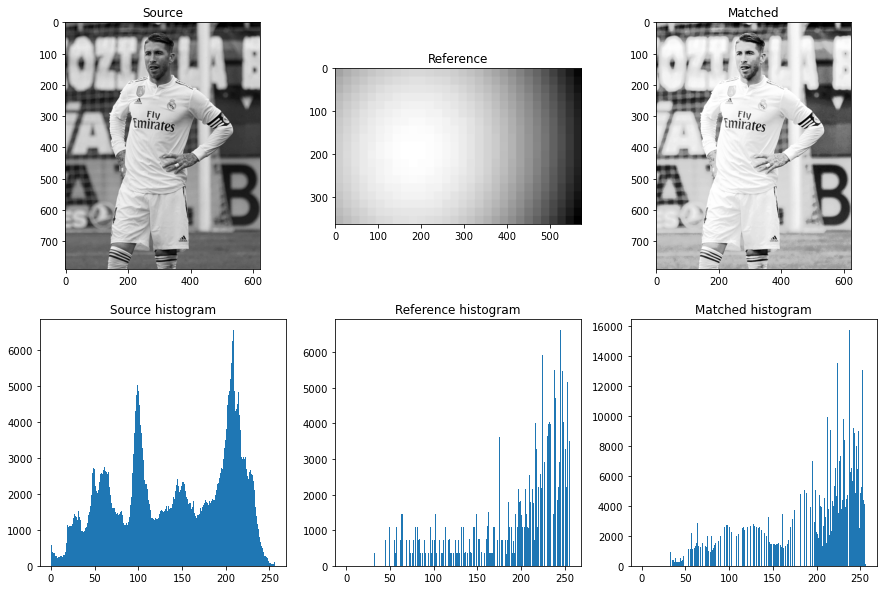

In [10]:
# ASSIGNMENT 3
# Write your code here!
from skimage.exposure import match_histograms

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

image = cv2.imread(images_path + 'ramos.jpg',0)
reference = cv2.imread(images_path + 'illumination.png',0)

matched = match_histograms(image, reference)

# Plot results
plt.subplot(231)
plt.imshow(image, cmap='gray')
plt.title('Source')

plt.subplot(232)
plt.imshow(reference, cmap='gray')
plt.title('Reference')

plt.subplot(233)
plt.imshow(matched, cmap='gray')
plt.title('Matched')

plt.subplot(234)
plt.hist(image.ravel(),256,[0,256])
plt.title('Source histogram')

plt.subplot(235)
plt.hist(reference.ravel(),256,[0,256])
plt.title('Reference histogram')

plt.subplot(236)
plt.hist(matched.ravel(),256,[0,256])
plt.title('Matched histogram')

## Conclusion

Great! We are sure that UMA users are going to appreciate your efforts. Also, next time you use an image editor tool you are going to have another point of view of how things work.

In conclusion, in this notebook you have learned:

- How to define a **gamma correction (non-linear) LUT** and to how to apply it to an image.
- How **histogram specification** works and its applications. When the specified histogram is uniformly distributed, we call it **histogram equalization**.

## Extra

But this doesn't have to be the end, open GIMP and look through others implemented methods.  

As you are learning about image processing, **comment how you think they are implemented from scratch.**